In [1]:
!pip install tensorflow

# Step 1: Import Dependencies

In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import zipfile
import tensorflow as tf
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Step 2: Set GPU Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [4]:
# Check if GPU is available
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Check GPU details
!nvidia-smi

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tue Mar 18 12:40:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |               

# Step 3: Data Pre-processing

## 1. Load Dataset

In [5]:
# Load LFW dataset (only identities with at least 10 images)
lfw = fetch_lfw_people(min_faces_per_person=10, resize=1.0, color=True)

## 2. Extract Images & Labels

In [6]:
# Extract images and labels
X = lfw.images  # Image data
y = lfw.target  # Integer labels
class_names = lfw.target_names  # Names of individuals

## 3. Split Dataset into Training, Validation, and Test sets

Total images: 3023
Image shape: (125, 94, 3)
Number of identities: 62
Training set: (1934, 125, 94, 3), Test set: (605, 125, 94, 3)


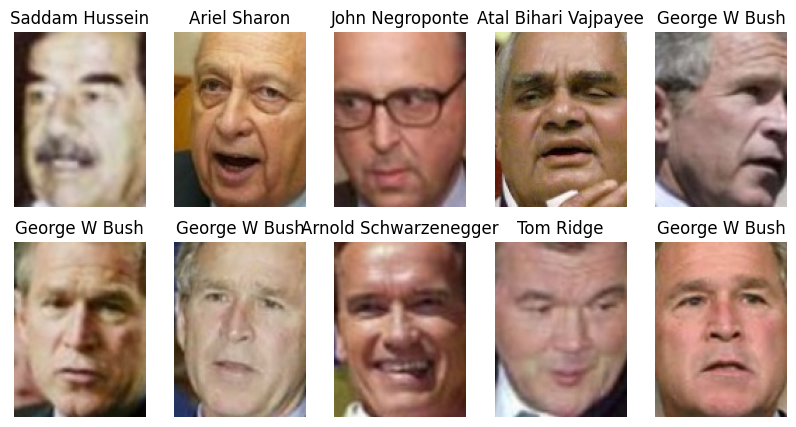

In [7]:
# Train-validation-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Calculate num_classes based on the number of unique individuals in the dataset
num_classes = len(class_names)

# Convert labels to one-hot encoding
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Print dataset info
print(f"Total images: {len(lfw.images)}")
print(f"Image shape: {lfw.images[0].shape}")
print(f"Number of identities: {len(class_names)}")
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Display some sample images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].squeeze(), cmap="gray")
    ax.set_title(class_names[np.argmax(y_train_cat[i])])
    ax.axis("off")

plt.show()

# Step 4: Image Pre-processing

In [8]:
# # Resize images to match model input size
# def resize_images(images, size=(64, 64)):
#     """
#     Resize images to the specified size (default: 64x64).
#     Ensures the output is in BGR format with 3 channels.
#     """
#     resized_images = []
#     for img in images:
#         # Check if the image already matches the desired size
#         if img.shape[:2] != size:
#             resized = cv2.resize(img, size, interpolation=cv2.INTER_AREA)  # Use INTER_AREA for downscaling
#             if resized.shape != (size[0], size[1], 3):  # Ensure 3-channel output
#                 resized = cv2.cvtColor(resized, cv2.COLOR_GRAY2BGR)  # Convert grayscale to 3 channels
#             resized_images.append(resized)
#         else:
#             resized_images.append(img)  # Keep the original image if it already matches the size
#     return np.array(resized_images)

# # Apply gradient transformation (edge enhancement)
# def apply_gradient(image, edge_threshold=50):
#     """
#     Apply gradient transformation to enhance edges in the image.
#     Returns the image in BGR format.
#     """
#     # Convert to grayscale
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     # Compute gradients in x and y directions using Sobel
#     grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
#     grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
#     # Combine gradients to get the magnitude
#     grad = np.sqrt(grad_x**2 + grad_y**2)
#     # Check if the maximum gradient magnitude exceeds the threshold
#     if grad.max() > edge_threshold:
#         print("Significant edges detected. Applying gradient transformation.")
#         # Normalize to [0, 255] for visualization
#         grad = cv2.normalize(grad, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
#         # Convert back to 3 channels for consistency
#         grad = cv2.cvtColor(grad, cv2.COLOR_GRAY2BGR)
#         return grad
#     else:
#         print("No significant edges detected. Skipping gradient transformation.")
#         return image  # Return the original image if no significant edges are found

# # Check if an image has low contrast
# def is_low_contrast(image, fraction_threshold=0.04):
#     """
#     Check if the image has low contrast based on the standard deviation of pixel intensities.
#     Handles both grayscale (1 channel) and BGR (3 channels) images.
#     """
#     # Check if the image is already grayscale
#     if len(image.shape) == 2 or image.shape[2] == 1:
#         gray = image  # Image is already grayscale
#     else:
#         # Convert to grayscale if the image is in BGR format
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # Compute the standard deviation of pixel intensities
#     std_dev = np.std(gray)
#     return std_dev < fraction_threshold * 255

# def contrast_enhance(img, fraction_threshold=0.04):
#     """
#     Enhance the contrast of the image using histogram equalization in L*a*b color space.
#     Returns the image in BGR format.
#     """
#     if is_low_contrast(img, fraction_threshold=fraction_threshold):
#         print("Low contrast detected. Applying contrast enhancement.")
#         # Convert to L*a*b color space
#         img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
#         # Split into channels
#         L, a, b = cv2.split(img_lab)

#         # Ensure the L channel is in the correct format (CV_8UC1)
#         if L.dtype != np.uint8:
#             L = np.uint8(L)  # Convert to 8-bit unsigned integer if necessary

#         # Apply histogram equalization to the L channel (lightness)
#         L = cv2.equalizeHist(L)

#         # Ensure all channels have the same size and data type
#         if L.shape != a.shape or L.shape != b.shape:
#             raise ValueError("Channels L, a, and b must have the same size.")
#         if a.dtype != np.uint8:
#             a = np.uint8(a)
#         if b.dtype != np.uint8:
#             b = np.uint8(b)

#         # Merge channels and convert back to BGR
#         img_lab_merge = cv2.merge((L, a, b))
#         enhanced_img = cv2.cvtColor(img_lab_merge, cv2.COLOR_Lab2BGR)
#         return enhanced_img
#     else:
#         print("Image has sufficient contrast. No enhancement applied.")
#         return img

# # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
# def apply_clahe(image, contrast_threshold=0.05):
#     """
#     Apply CLAHE to enhance local contrast in the image.
#     Returns the image in BGR format.
#     """
#     # Convert to L*a*b color space
#     lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
#     # Split into channels
#     l, a, b = cv2.split(lab)
#     # Check if the image has low local contrast
#     if is_low_contrast(l, fraction_threshold=contrast_threshold):
#         print("Low local contrast detected. Applying CLAHE.")
#         # Apply CLAHE to the L channel
#         clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#         l_clahe = clahe.apply(l)
#         # Merge channels and convert back to BGR
#         lab_clahe = cv2.merge((l_clahe, a, b))
#         return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
#     else:
#         print("Sufficient local contrast. Skipping CLAHE.")
#         return image  # Return the original image if local contrast is sufficient

# # Apply noise reduction using Gaussian blur
# def apply_noise_reduction(image, noise_threshold=10):
#     """
#     Apply Gaussian blur to reduce noise in the image.
#     Returns the image in BGR format.
#     """
#     # Convert to grayscale
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     # Compute the standard deviation of pixel intensities
#     std_dev = np.std(gray)
#     # Check if the image is noisy
#     if std_dev > noise_threshold:
#         print("Noisy image detected. Applying noise reduction.")
#         return cv2.GaussianBlur(image, (5, 5), 0)
#     else:
#         print("Image is not noisy. Skipping noise reduction.")
#         return image  # Return the original image if it's not noisy

# # Main preprocessing function
# def preprocess_image(image):
#     """
#     Apply all preprocessing steps to the image.
#     Returns the preprocessed image in BGR format.
#     """
#     # Resize image
#     resized = cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA)
#     if resized.shape != (64, 64, 3):  # Ensure 3-channel output
#         resized = cv2.cvtColor(resized, cv2.COLOR_GRAY2BGR)

#     # Apply noise reduction
#     denoised = apply_noise_reduction(resized)

#     # Apply contrast enhancement
#     enhanced = contrast_enhance(denoised)

#     # Apply CLAHE for local contrast enhancement
#     clahe_applied = apply_clahe(enhanced)

#     # Apply gradient transformation for edge enhancement
#     final_image = apply_gradient(clahe_applied)

#     return final_image

# # Preprocess the dataset
# X_train_processed = np.array([preprocess_image(img) for img in X_train])
# X_val_processed = np.array([preprocess_image(img) for img in X_val])
# X_test_processed = np.array([preprocess_image(img) for img in X_test])

In [9]:
# Resize images to match model input size
def resize_images(images, size=(64, 64)):
    resized_images = []
    for img in images:
        resized = cv2.resize(img, size)
        if resized.shape != (size[0], size[1], 3):  # Check for correct shape
            resized = cv2.cvtColor(resized, cv2.COLOR_GRAY2BGR)  # Convert to RGB if needed
        resized_images.append(resized)
    return np.array(resized_images)

# Apply gradient transformation
def apply_gradient(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Compute gradients in x and y directions
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    # Combine gradients
    grad = np.sqrt(grad_x**2 + grad_y**2)
    # Normalize to [0, 255]
    grad = cv2.normalize(grad, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    # Convert back to 3 channels
    grad = cv2.cvtColor(grad, cv2.COLOR_GRAY2BGR)
    return grad

# Apply histogram equalization
def apply_histogram_equalization(image):
    # Convert to YCrCb color space
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    # Apply histogram equalization to the Y channel
    ycrcb[:, :, 0] = cv2.equalizeHist(ycrcb[:, :, 0])
    # Convert back to BGR
    equalized = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)
    return equalized

# Preprocess images with gradient transformation and histogram equalization
def preprocess_images(images):
    processed_images = []
    for img in images:
        # Apply gradient transformation
        grad = apply_gradient(img)
        # Apply histogram equalization
        equalized = apply_histogram_equalization(grad)

        processed_images.append(equalized)
    return np.array(processed_images)



In [10]:
# Preprocess the dataset
X_train_resized = resize_images(X_train)
X_val_resized = resize_images(X_val)
X_test_resized = resize_images(X_test)

X_train_processed = preprocess_images(X_train_resized)
X_val_processed = preprocess_images(X_val_resized)
X_test_processed = preprocess_images(X_test_resized)

# Convert labels to categorical
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Step 5: Data Augmentation

In [11]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train_processed)

In [12]:
# Generate augmented images and expand the training set
augmented_images = []
augmented_labels = []

# Generate samples manually
num_augmented = 5  # Number of augmented images per original image
for x, y in zip(X_train_processed, y_train_cat):
    x = np.expand_dims(x, axis=0)  # Reshape for ImageDataGenerator
    it = datagen.flow(x, np.array([y]), batch_size=1)  # Single sample batch
    for _ in range(num_augmented):
        aug_img, aug_label = next(it)  # Use next(it) instead of it.next()
        augmented_images.append(aug_img[0])  # Extract array from batch
        augmented_labels.append(aug_label[0])

# Convert to numpy arrays
X_train_augmented = np.array(augmented_images)
y_train_augmented = np.array(augmented_labels)

# Combine original and augmented datasets
X_train_final = np.concatenate((X_train_processed, X_train_augmented), axis=0)
y_train_final = np.concatenate((y_train_cat, y_train_augmented), axis=0)

print(f"Before Augmentation: {X_train_processed.shape[0]}")
print(f"After Augmentation: {X_train_final.shape[0]}")


Before Augmentation: 1934
After Augmentation: 11604


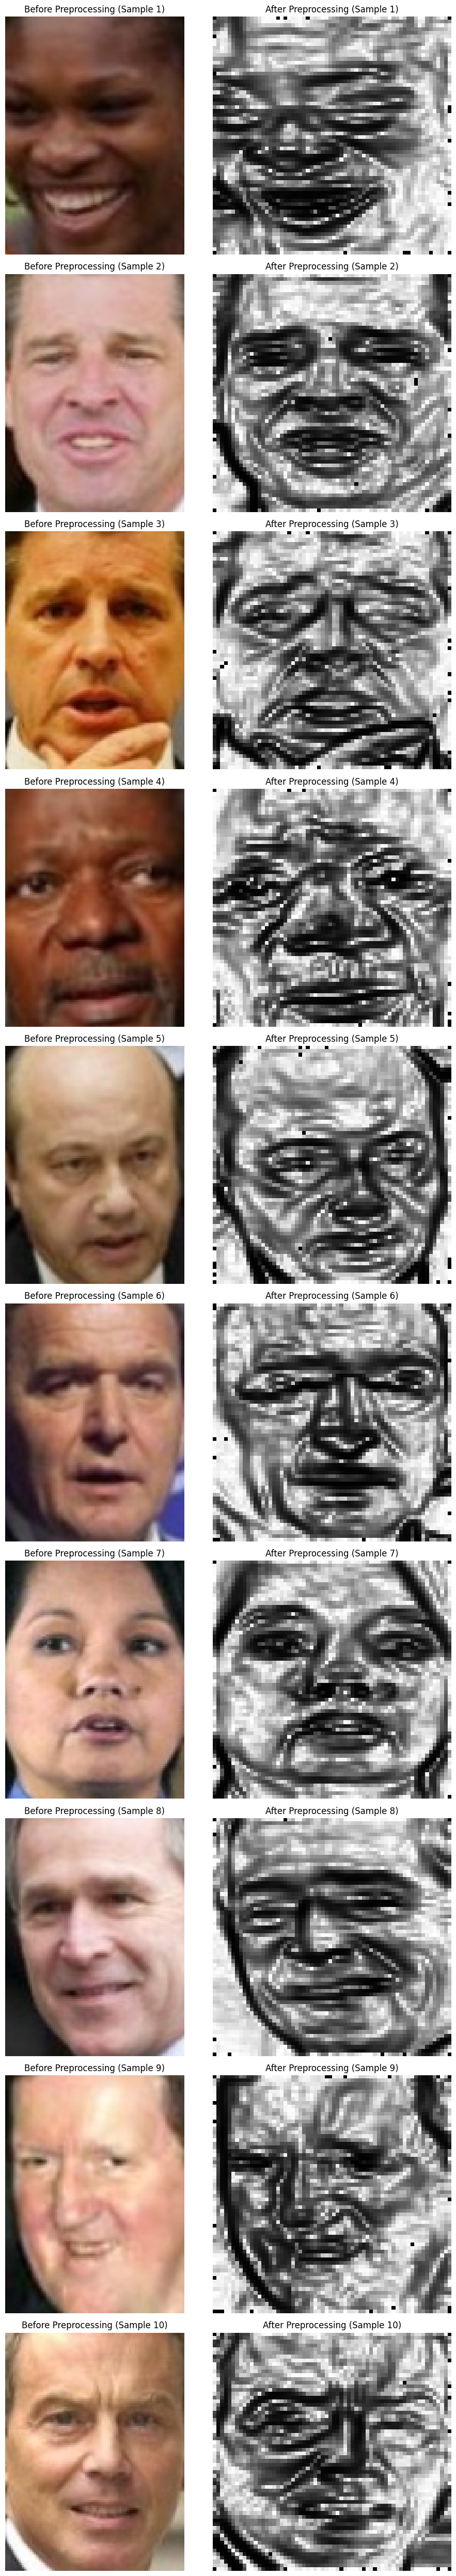

In [26]:
# Function to display before and after images
def display_before_after_images(before_images, after_images, num_samples=10):
    sample_indices = random.sample(range(len(before_images)), num_samples)

    plt.figure(figsize=(10, 5 * num_samples))
    for i, idx in enumerate(sample_indices):
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(before_images[idx])
        plt.title(f"Before Preprocessing (Sample {i + 1})")
        plt.axis("off")

        # Reverse normalization for visualization
        visualize_image = (after_images[idx] * 255).astype(np.uint8)
        visualize_image = np.clip(visualize_image, 0, 255) #ensure that all values are inside of the 0 to 255 range.

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(visualize_image)
        plt.title(f"After Preprocessing (Sample {i + 1})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Display before and after images
display_before_after_images(X_train, X_train_processed, num_samples=10)

# Step 6: Model Training and Evaluation

In [14]:
EMBEDDING_SIZE = 512

In [15]:
from tensorflow.keras.layers import Add, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply, DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.callbacks import ModelCheckpoint

In [16]:
def create_conv_block(x, filters, kernel_size=(3, 3), padding="same", dropout_rate=0.0, l2_reg=0.001):
    """
    Creates a convolutional block with Conv2D, BatchNormalization, and Dropout.
    """
    x = Conv2D(filters, kernel_size, padding=padding, kernel_regularizer=l2(l2_reg), activation="relu")(x)
    x = BatchNormalization()(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    return x

def create_residual_block(x, filters, l2_reg=0.001, strides=(1, 1)):
    """Residual Blocks: The core change is the introduction of create_residual_block.
    This function implements residual connections, a key technique for training deeper and more effective CNNs.
    Residual connections help to alleviate the vanishing gradient problem, allowing the model to learn more complex features.
    """
    shortcut = x

    x = create_conv_block(x, filters, kernel_size=(3, 3), padding="same", dropout_rate=0.0, l2_reg=l2_reg)
    x = create_conv_block(x, filters, kernel_size=(3, 3), padding="same", dropout_rate=0.0, l2_reg=l2_reg)

    # Modify the shortcut connection to match the output channels
    if shortcut.shape[-1] != filters or strides != (1, 1):
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding="same",
                          kernel_regularizer=l2(l2_reg))(shortcut)
        shortcut = BatchNormalization()(shortcut)  # Optional: Add batch normalization to shortcut

    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x

def create_cnn_model(input_shape, num_classes, l2_reg=0.001):
    inputs = Input(shape=input_shape)

    x = create_residual_block(inputs, 32, l2_reg=l2_reg)
    x = create_residual_block(x, 64, l2_reg=l2_reg)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = create_residual_block(x, 128, l2_reg=l2_reg)
    x = create_residual_block(x, 128, l2_reg=l2_reg)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    x = create_residual_block(x, 256, l2_reg=l2_reg)
    x = create_residual_block(x, 256, l2_reg=l2_reg)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)

    x = GlobalAveragePooling2D()(x)
    embeddings = Dense(EMBEDDING_SIZE, activation="relu", name="embedding_layer")(x)
    outputs = Dense(num_classes, activation="softmax")(embeddings)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0005), metrics=["accuracy"])
    model.summary()
    return model

# Define input shape
input_shape = (64, 64, 3)  # Correct input shape for RGB

# Create and compile the model
model = create_cnn_model(input_shape, num_classes)

# Compute class weights for imbalanced data
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Define callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    datagen.flow(X_train_processed, y_train_cat, batch_size=32),
    epochs=200,
    validation_data=(X_val_processed, y_val_cat),  # Use validation set
    class_weight=class_weights_dict,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │            128 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 32)     │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 32)     │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 32)     │              0 │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 64, 64, 32)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │          2,112 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 64, 64, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 64, 64, 64)     │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 64, 64, 64)     │              0 │ batch_normalization_4… │
│                      

 Total params: 2,863,390 (10.92 MB)

 Trainable params: 2,858,974 (10.91 MB)

 Non-trainable params: 4,416 (17.25 KB)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 54s 462ms/step - accuracy: 0.0092 - loss: 6.3349 - val_accuracy: 0.0083 - val_loss: 6.4798 - learning_rate: 5.0000e-04
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.0117 - loss: 5.9893 - val_accuracy: 0.0186 - val_loss: 5.8461 - learning_rate: 5.0000e-04
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.0096 - loss: 5.8677 - val_accuracy: 0.0083 - val_loss: 6.1857 - learning_rate: 5.0000e-04
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.0180 - loss: 5.6069 - val_accuracy: 0.0124 - val_loss: 5.6501 - learning_rate: 5.0000e-04
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.0155 - loss: 5.5984 - val_accuracy: 0.0723 - val_loss: 5.4341 - learning_rate: 5.0000e-04
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.0225 - loss: 5.3773 - val_accuracy: 0.0558 - val_loss: 5.2369 - learning_rate: 5.0000e-04
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.0269 - 

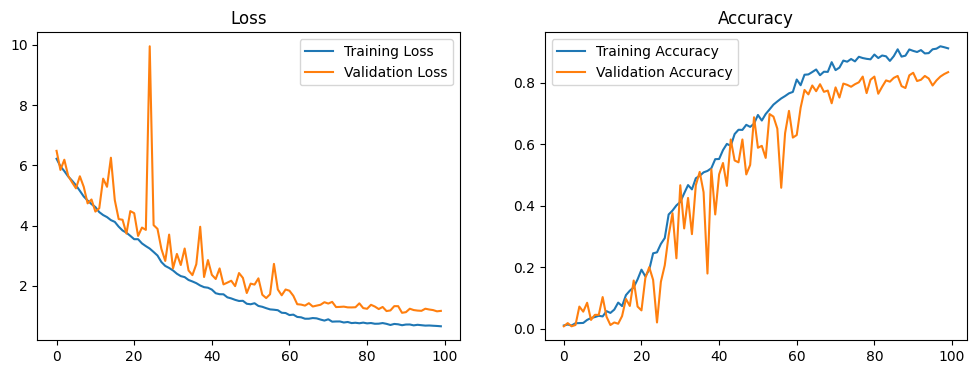

In [17]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.show()

plot_history(history)

In [18]:
# Evaluate the model on the test setX_test_processed, y_test_cat
test_loss, test_acc = model.evaluate(X_test_processed, y_test_cat)
print(f"Test accuracy: {test_acc:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.8425 - loss: 1.0657
Test accuracy: 0.8479


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


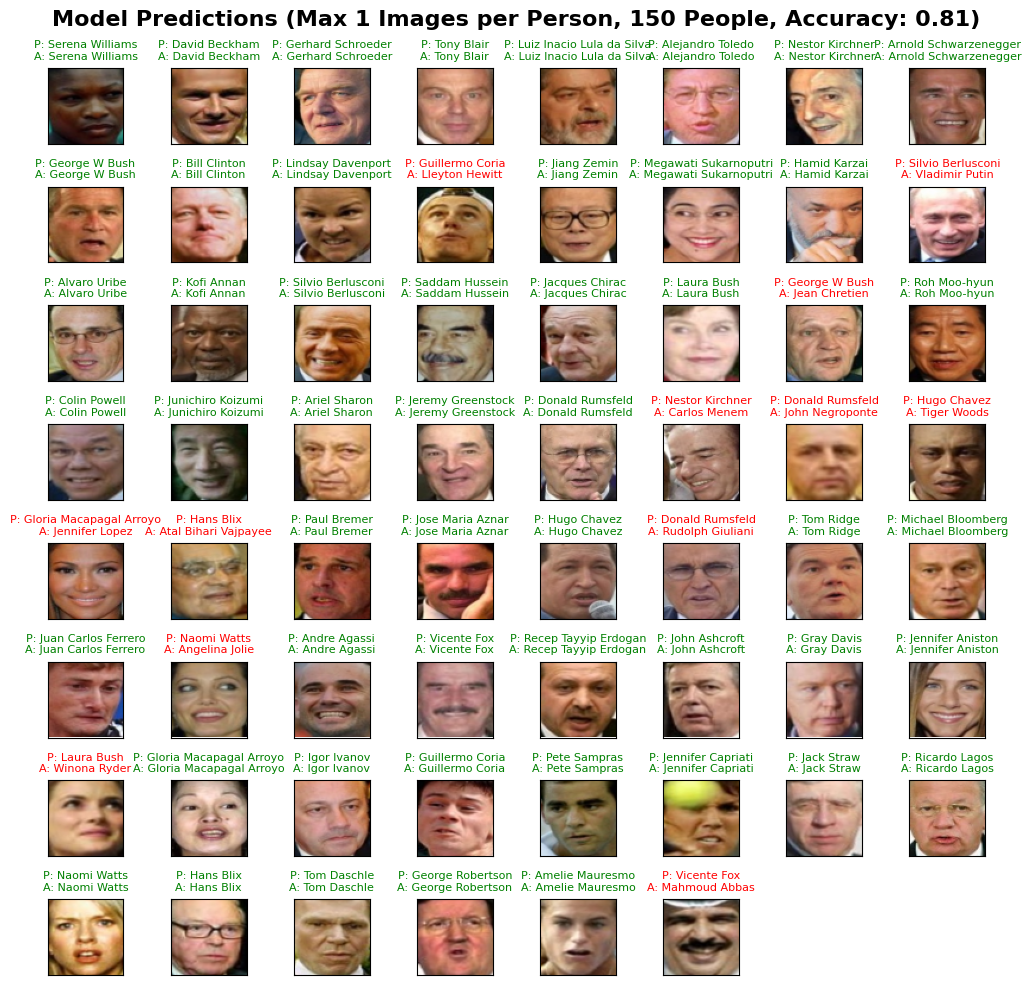

In [27]:
y_pred_probs = model.predict(X_test_processed)
y_pred = np.argmax(y_pred_probs, axis=1)
y_actual = np.argmax(y_test_cat, axis=1)
class_names = lfw.target_names

unique_indices = []
person_count = {}  # Track occurrences of each person
max_occurrences = 1  # Max times a person can appear
num_people = 150  # Number of unique individuals to display

correct_count = 0  # Count correct predictions for the displayed subset

for i, label in enumerate(y_actual):
    if person_count.get(label, 0) < max_occurrences:
        unique_indices.append(i)
        person_count[label] = person_count.get(label, 0) + 1
        if y_pred[i] == y_actual[i]:
            correct_count += 1
    if len(person_count) >= num_people and all(v >= max_occurrences for v in person_count.values()):
        break

accuracy = correct_count / len(unique_indices) if len(unique_indices) > 0 else 0

plt.figure(figsize=(10, 10))
grid_size = int(np.ceil(np.sqrt(len(unique_indices))))  # Adjust grid size dynamically

for i, idx in enumerate(unique_indices):
    plt.subplot(grid_size, grid_size, i + 1)

    image_to_display = X_test_resized[idx]

    # Handle Grayscale or RGB display
    if image_to_display.shape == (64, 64, 1):  # Grayscale
        image_to_display = np.repeat(image_to_display, 3, axis=-1)  # Convert to RGB for display
        plt.imshow(image_to_display, cmap='gray')  # Use correct cmap
    elif image_to_display.shape == (64, 64, 3):  # RGB
        plt.imshow(image_to_display)
    else:
        print("Image shape not recognized.")

    try:  # Handle potential index errors
        pred_name = class_names[y_pred[idx]]
        actual_name = class_names[y_actual[idx]]
        color = "green" if y_pred[idx] == y_actual[idx] else "red"
        plt.title(f"P: {pred_name}\nA: {actual_name}", color=color, fontsize=8)
    except IndexError as e:
        print(f"Error accessing class names: {e}, index: {idx}")

    plt.xticks([]), plt.yticks([])

plt.suptitle(f"Model Predictions (Max 1 Images per Person, 150 People, Accuracy: {accuracy:.2f})",
             fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


# Step 7: Save Trained Model

In [20]:
# Save the trained model
model.save("cnn_face_model.h5")
print("Model saved successfully!")


Model saved successfully!


# Step 8: Test the model with custom dataset

In [21]:
# Load the trained model
face_model = tf.keras.models.load_model("cnn_face_model.h5", compile=False)
print("Model loaded successfully!")


Model loaded successfully!


In [22]:
face_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │            128 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 32)     │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 32)     │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 32)     │              0 │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 64, 64, 32)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │          2,112 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 64, 64, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 64, 64, 64)     │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 64, 64, 64)     │              0 │ batch_normalization_4… │
│                      

 Total params: 2,863,390 (10.92 MB)

 Trainable params: 2,858,974 (10.91 MB)

 Non-trainable params: 4,416 (17.25 KB)

Test Loss: 1.0537376403808594
Test Accuracy: 0.8479338884353638
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Classification Report:
                           precision    recall  f1-score   support

         Alejandro Toledo       0.73      1.00      0.84         8
             Alvaro Uribe       1.00      1.00      1.00         7
          Amelie Mauresmo       1.00      0.75      0.86         4
             Andre Agassi       0.45      0.71      0.56         7
           Angelina Jolie       1.00      0.50      0.67         4
             Ariel Sharon       0.88      0.94      0.91        16
    Arnold Schwarzenegger       0.75      0.75      0.75         8
     Atal Bihari Vajpayee       0.80      0.80      0.80         5
             Bill Clinton       0.80      0.67      0.73         6
             Carlos Menem       1.00      0.50      0.67         4
             Colin Powell       0.97      0.83      0.90        47
            David Beckham       0.75      0.50      0.60         6
 

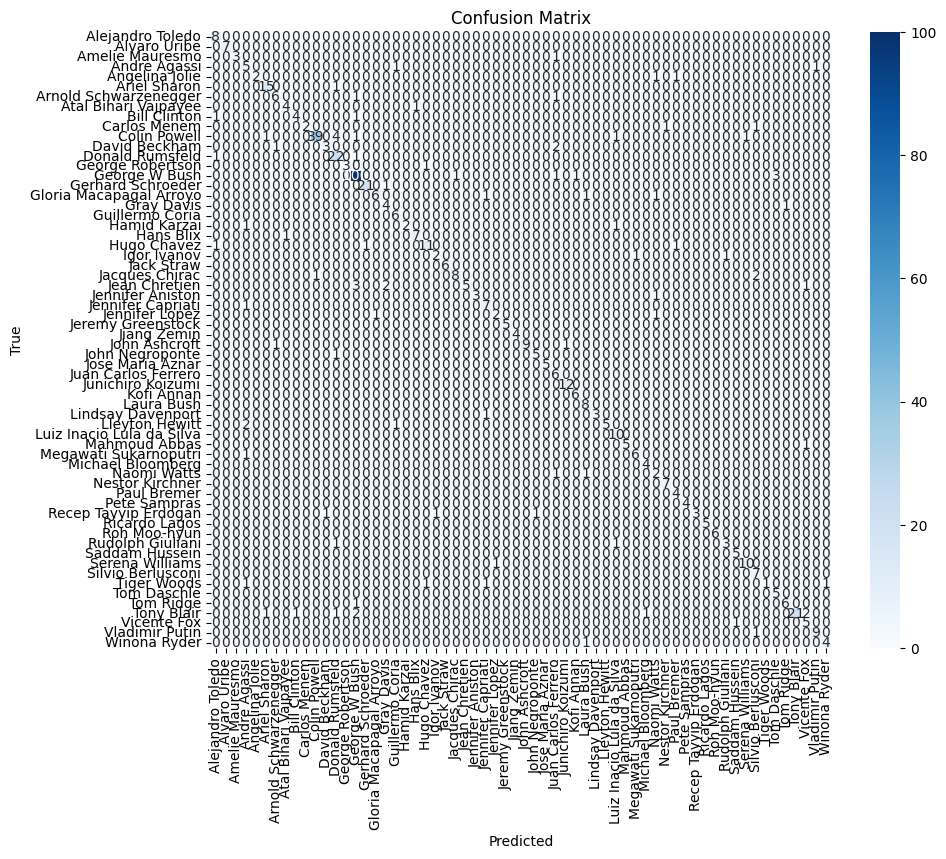

In [23]:


# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test_processed, y_test_cat, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on the test set
y_pred = model.predict(X_test_processed)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### step 1: Get Face from camera



In [24]:
for layer in face_model.layers:
    print(layer.name)  # Print all layer names

print(face_model.input_shape)

input_layer
conv2d
batch_normalization
conv2d_1
conv2d_2
batch_normalization_1
batch_normalization_2
add
activation
conv2d_3
batch_normalization_3
conv2d_4
conv2d_5
batch_normalization_4
batch_normalization_5
add_1
activation_1
max_pooling2d
dropout
conv2d_6
batch_normalization_6
conv2d_7
conv2d_8
batch_normalization_7
batch_normalization_8
add_2
activation_2
conv2d_9
batch_normalization_9
conv2d_10
batch_normalization_10
add_3
activation_3
max_pooling2d_1
dropout_1
conv2d_11
batch_normalization_11
conv2d_12
conv2d_13
batch_normalization_12
batch_normalization_13
add_4
activation_4
conv2d_14
batch_normalization_14
conv2d_15
batch_normalization_15
add_5
activation_5
max_pooling2d_2
dropout_2
global_average_pooling2d
embedding_layer
dense
(None, 64, 64, 3)


In [25]:
# Now create the feature extractor
feature_extractor = Model(inputs=face_model.input, outputs=face_model.get_layer("embedding_layer").output)
